In [1]:
import pandas as pd
from skmultilearn.problem_transform import ClassifierChain
from sklearn.svm import SVC
from sklearn.model_selection import KFold

In [2]:
###Laod data
df = pd.read_csv('../data/Finalplfam_id_Multilabel_Ecoli_data.csv', dtype=str, index_col=0)

In [3]:
Labeldf = pd.read_csv('../data/'+'AMR_LAbel_EColi.csv',index_col=0) 

In [7]:
Ycolumns=Labeldf.columns.values

In [8]:
Y=df[Ycolumns]
Y=Y.drop(columns=['genome_id', 'genome_name','taxon_id'])

X=df.drop(columns=Ycolumns)

In [9]:
Labellist=Ycolumns.tolist()
Labellist.remove('genome_id')
Labellist.remove('genome_name')
Labellist.remove('taxon_id')

In [10]:
kfold = KFold(n_splits=5)
scorelist=[]

In [30]:
Y=Y.replace(to_replace=['Not defined','Susceptible-dose dependent'], value=[np.nan,0])

In [11]:
X=X.fillna(0)
X = X.apply(pd.to_numeric)

In [18]:
def hamming_score(y_pred,y_true):
    i=0
    scorelist=[]
    for  amrtrue in y_true:
        match=0.0
        total=0.0
        #print(amrtrue, y_pred[i])
        j=0
        for trueentry in amrtrue:
            #print(trueentry)
            if (trueentry == y_pred[i][j]):
                #print ('match found')
                match=match+1
                total=total+1
            elif (not (np.isnan(trueentry))):
                total = total + 1
            j=j+1
        i=i+1
        #print (match, total, (match/total))
        scorelist.append(match/total)
    return np.mean(scorelist)

In [19]:
import numpy as np
def Modified_F1_Score(y_pred,y_true):
    #i=0
    scorelist=[]
    for  i,amrtrue in enumerate(y_true):
        TP,FP,TN,FN=0.00000001,0.00000001,0.00000001,0.00000001
        #j=0
        for j,trueentry in enumerate(amrtrue):
            if ((np.isnan(trueentry))):
                continue
            elif ((trueentry == 1) and (y_pred[i][j]==1)):
                TP=TP+1
            elif ((trueentry == 1) and (y_pred[i][j]==0)):
                FN=FN+1
            elif ((trueentry == 0) and (y_pred[i][j]==0)):
                TN=TN+1
            elif ((trueentry == 0) and (y_pred[i][j]==1)):
                FP=FP+1
            #j=j+1
        #i=i+1
        precision=TP/(TP+FP)
        recall=TP/(TP+FN)
        fscore=(2*precision*recall)/(precision+recall)
        scorelist.append(fscore)
    return np.mean(scorelist)

In [20]:
import matplotlib.pyplot as plt
import seaborn as sb

sb.set_context("talk")
def plot_coefficients(feature_names, coef, name, top_features=20):
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    #top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients =top_positive_coefficients# np.hstack([top_positive_coefficients])
    # create plot
    plt.figure(figsize=(10, 5))
    plt.title("Feature Importances Multi AMR for "+str(name), y=1.08)
    colors = ['crimson' if c < 0 else 'cornflowerblue' for c in coef[top_coefficients]]
    plt.bar(np.arange(1 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(0, 1 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
    plt.show()
    np.asarray(feature_names)[top_positive_coefficients]

In [21]:
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier

In [22]:
####Base models
xgbmodel = XGBClassifier()
adaboostmodel = AdaBoostClassifier(n_estimators=100, random_state=0)
modellist=[xgbmodel,adaboostmodel]
namelist=['xgb','AdaBoost']

In [23]:
import time
times=[]
methods=[]

In [24]:
from skmultilearn.problem_transform import BinaryRelevance

In [25]:
def BinaryRelevanceModel(X,Y,kfold, basemodel, name, times, methods):
    classifier = BinaryRelevance(basemodel)
    hammingscorelist=[]
    fscorelist=[]
    for train_index, test_index in kfold.split(X, Y):
        start = time.process_time()
        # split data into train/test sets
        x_train_tfidf = X.iloc[train_index]
        y_train_tfidf = Y.iloc[train_index]
        x_test_tfidf = X.iloc[test_index]
        y_test_tfidf = Y.iloc[test_index]
        y_train_tfidf=y_train_tfidf.fillna(0)
        y_train_tfidf = y_train_tfidf.apply(pd.to_numeric)
        y_train_tfidf=y_train_tfidf.astype(int)
        y_test_tfidf = y_test_tfidf.apply(pd.to_numeric)
        #y_test_tfidf=y_test_tfidf.astype(int)
        classifier.fit(x_train_tfidf.values, y_train_tfidf.values)
        # calculating test accuracy
        prediction = classifier.predict(x_test_tfidf.values)
        hammingscore=hamming_score(prediction.toarray(),y_test_tfidf.values)
        fscore=Modified_F1_Score(prediction.toarray(),y_test_tfidf.values)
        print(fscore, hammingscore)
        hammingscorelist.append(hammingscore)
        fscorelist.append(fscore)
        times = np.append(times, (time.process_time() - start))
        methods = np.append(methods, 'BR-'+name)
    print ('Base model for BR is {}'.format(name))
    print('Test Hamming accuracy for Binary relvance is {}'.format(np.mean(hammingscorelist)))
    print('Test F-score accuracy for Binary relvance is {}'.format(np.mean(fscorelist)))
    print('Hamming std'+str(np.std(hammingscorelist)))
    print('F-Score std'+str(np.std(fscorelist)))
    return np.mean(hammingscorelist),np.mean(fscorelist),np.std(hammingscorelist),np.std(fscorelist), times, methods


In [31]:
i=0
for basemodel in modellist:
    hamming, fscore, hmstd, fstd, times, methods=BinaryRelevanceModel(X,Y,kfold,basemodel,namelist[i], times, methods)
    i=i+1

C:\Users\mt01034\Anaconda3\envs\MLEnv\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:10:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:10:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:10:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:11:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[17:15:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:15:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:15:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:16:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[17:20:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:20:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:20:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:20:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[17:25:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:25:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:25:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:25:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[17:30:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:30:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:30:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:31:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[17:35:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:35:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:35:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:36:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [32]:
print("Before removing low variance: ", X.shape)
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold(threshold=0.01)
selector.fit_transform(X)
X = X[X.columns[selector.get_support()]].copy()
print("After removing low variance: ", X.shape)

Before removing low variance:  (2775, 16345)
After removing low variance:  (2775, 8763)


In [33]:
modellist=[xgbmodel]
namelist=['xgb']

In [34]:
from RectifiedClassifierChain import RectifiedClassiferChain

In [35]:
import shap

In [36]:
def RCCModelwithMR(X,Y,kfold, basemodel, name, times, methods,shapTotal, type=0):
    sim_all_df = pd.DataFrame()
    hammingscorelist=[]
    fscorelist=[]
    for train_index, test_index in kfold.split(X, Y):
        # split data into train/test sets
        start = time.process_time()
        x_train_tfidf = X.iloc[train_index]
        y_train_tfidf = Y.iloc[train_index]
        x_test_tfidf = X.iloc[test_index]
        y_test_tfidf = Y.iloc[test_index]
        x_train_tfidf=x_train_tfidf.reset_index(drop=True)
        y_train_tfidf=y_train_tfidf.reset_index(drop=True)
        y_train_tfidf = y_train_tfidf.apply(pd.to_numeric)
        #y_train_tfidf=y_train_tfidf.astype(int)
        y_test_tfidf = y_test_tfidf.apply(pd.to_numeric)
        classifier=RectifiedClassiferChain(basemodel,optimized=True,optimizedmethod='MissingRatio')
        classifier.trainRCC(x_train_tfidf, y_train_tfidf)
        # calculating test accuracy
        x_test_tfidf=x_test_tfidf.reset_index(drop=True)
        y_test_tfidf=y_test_tfidf.reset_index(drop=True)
        prediction = classifier.predictRCC(x_test_tfidf)
        hammingscore, fscore=classifier.Evaluate(y_test_tfidf,prediction)
        
        #hammingscore1=hamming_score(np.array(prediction),y_test_tfidf.values)
        #fscore1=Modified_F1_Score(np.array(prediction),y_test_tfidf.values)
        
        print(hammingscore,fscore)
        #print(hammingscore1,fscore1)
        hammingscorelist.append(hammingscore)
        fscorelist.append(fscore)
        times = np.append(times, (time.process_time() - start))
        methods = np.append(methods, 'RCC_MR-'+name)
        label_order=classifier.getOptimizedLabelOrder()
        print (label_order)
        if(type !=2):
            featuredf=classifier.getFeature(NoOfFeature=100,type=type,full=True)
            #featuredf.to_csv('Test.csv')
            sim_all_df = pd.concat([sim_all_df, featuredf], ignore_index=True)
        if(type==3):
            shapValue=classifier.getShapFeatures()
            shapTotal.append(shapValue)
    print ('Base model for RCC is {}'.format(name))
    print('Test Hamming accuracy for RCC is {}'.format(np.mean(hammingscorelist)))
    print('Test F-score accuracy for RCC is {}'.format(np.mean(fscorelist)))
    print('Hamming std'+str(np.std(hammingscorelist)))
    print('F-Score std'+str(np.std(fscorelist)))
    if(type !=2):
        sim_all_df_T = sim_all_df.transpose().copy()
        sim_all_df_T["feature_weight_sum"] = sim_all_df_T.apply(lambda x: abs(x).sum(), axis=1)
        sim_all_df_T_top = sim_all_df_T.sort_values("feature_weight_sum", ascending=False)[:30]
        #sim_all_df_T_top.to_csv('Test.csv')
    else:
        sim_all_df_T_top=sim_all_df.copy()
    return np.mean(hammingscorelist),np.mean(fscorelist),sim_all_df_T_top, times, methods, shapTotal

In [ ]:
i=0

for basemodel in modellist:
    if(namelist[i] =='AdaBoost'):
        type=1
    elif(namelist[i] =='xgb'):
        type=3
    elif(namelist[i] =='Gaussian'):
        type=2
    else:
        type=0
    hamming, fscore, featuredf, times, methods, TotShape=RCCModelwithMR(X,Y,kfold,basemodel,namelist[i], times, methods, TotShape, type)
    if(type!=2):
        featuredf.to_csv('sim_all_df_T_RCC_MR_Sal'+str(namelist[i])+'.csv')
        #print(featuredf)
        plot_coefficients(list(featuredf.index),featuredf["feature_weight_sum"],namelist[i],30)
    if (type==3):
        TotShapedf = pd.DataFrame (np.vstack(TotShape), columns = [X.columns])
        shap.summary_plot(np.vstack(TotShape), features=X, feature_names=X.columns, plot_type="bar")
        TotShapedf.to_csv('Shape_Features_RCC_MR_all_Sal_'+str(namelist[i])+'.csv')
    i=i+1

In [38]:
from StackedClassifierChain import StackedClassifierChain 

In [39]:
def SCCModelwithSSC(X,Y,kfold, basemodel, name, times, methods, type=0):
    sim_all_df = pd.DataFrame()
    hammingscorelist=[]
    fscorelist=[]
    for train_index, test_index in kfold.split(X, Y):
        # split data into train/test sets
        start = time.process_time()
        x_train_tfidf = X.iloc[train_index]
        y_train_tfidf = Y.iloc[train_index]
        x_test_tfidf = X.iloc[test_index]
        y_test_tfidf = Y.iloc[test_index]
        x_train_tfidf=x_train_tfidf.reset_index(drop=True)
        y_train_tfidf=y_train_tfidf.reset_index(drop=True)
        y_train_tfidf=y_train_tfidf.fillna(0)
        y_train_tfidf = y_train_tfidf.apply(pd.to_numeric)
        y_train_tfidf=y_train_tfidf.astype(int)
        y_test_tfidf = y_test_tfidf.apply(pd.to_numeric)
        classifier=StackedClassifierChain(basemodel)
        classifier.trainSCC(x_train_tfidf, y_train_tfidf)
        # calculating test accuracy
        x_test_tfidf=x_test_tfidf.reset_index(drop=True)
        y_test_tfidf=y_test_tfidf.reset_index(drop=True)
        prediction = classifier.predictSCC(x_test_tfidf)
        hammingscore, fscore=classifier.Evaluate(y_test_tfidf,prediction)
        
        #hammingscore1=hamming_score(np.array(prediction),y_test_tfidf.values)
        #fscore1=Modified_F1_Score(np.array(prediction),y_test_tfidf.values)
        
        print(hammingscore,fscore)
        #print(hammingscore1,fscore1)
        hammingscorelist.append(hammingscore)
        fscorelist.append(fscore)
        times = np.append(times, (time.process_time() - start))
        methods = np.append(methods, 'SCC-'+name)
        if(type !=2):
            featuredf=classifier.getFeature(NoOfFeature=100,type=type,full=True)
            #featuredf.to_csv('Test.csv')
            sim_all_df = pd.concat([sim_all_df, featuredf], ignore_index=True)
    print ('Base model for SCC is {}'.format(name))
    print('Test Hamming accuracy for SCC is {}'.format(np.mean(hammingscorelist)))
    print('Test F-score accuracy for SCC is {}'.format(np.mean(fscorelist)))
    print('Hamming std'+str(np.std(hammingscorelist)))
    print('F-Score std'+str(np.std(fscorelist)))
    if(type !=2):
        sim_all_df_T = sim_all_df.transpose().copy()
        sim_all_df_T["feature_weight_sum"] = sim_all_df_T.apply(lambda x: abs(x).sum(), axis=1)
        sim_all_df_T_top = sim_all_df_T.sort_values("feature_weight_sum", ascending=False)[:30]
        sim_all_df_T_top.to_csv('SCCTest.csv')
    else:
        sim_all_df_T_top=sim_all_df.copy()
    return np.mean(hammingscorelist),np.mean(fscorelist),sim_all_df_T_top, times, methods

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[20:52:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:52:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:52:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:52:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[20:56:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:56:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:56:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:56:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[20:59:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:59:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:00:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:00:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[21:03:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:03:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:03:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:04:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[21:07:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:07:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:07:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:07:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[21:11:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:11:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:11:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:11:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

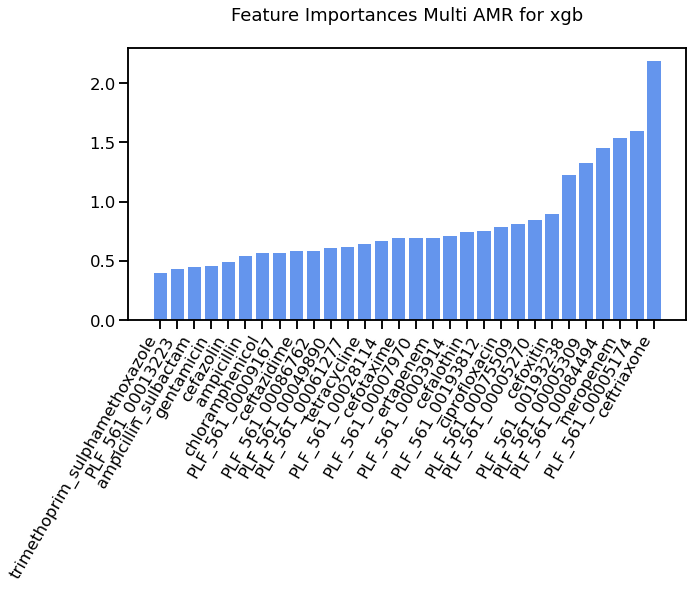

In [40]:
i=0
for basemodel in modellist:
    if(namelist[i] =='randomforest' or namelist[i] =='xgb' or namelist[i]=='AdaBoost'):
        type=1
    elif(namelist[i] =='Gaussian'):
        type=2
    else:
        type=0
    hamming, fscore, featuredf, times, methods=SCCModelwithSSC(X,Y,kfold,basemodel,namelist[i], times, methods,type)
    if(type!=2):
        featuredf.to_csv('sim_all_df_T_SCC_SSC_Sal'+str(namelist[i])+'.csv')
        #print(featuredf)
        plot_coefficients(list(featuredf.index),featuredf["feature_weight_sum"],namelist[i],30)
    i=i+1

In [ ]:
'''
XGB -A tree depth of 16 , 10-mers were used to build models from assembled genomes to ensure that all models would fit in memory
 learning rate was set to 0.0625
    column and row subsampling was set to 1.0 
     number of rounds of boosting was limited to 1000
'''

In [ ]:
'''
AdaBoost
K=31
'''

In [ ]:
'''
##https://journals.asm.org/doi/full/10.1128/JCM.01260-18
https://github.com/PATRIC3/mic_prediction
    
###https://github.com/TahaAslani/AAk-mer
https://www.mdpi.com/2079-7737/9/11/365/htm

##https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1008319
'''

In [ ]:
import shap
#explainer=shap.TreeExplainer(rf_classifier)
rf_shap_values = shap.KernelExplainer(rf_classifier.predict,X_test)

In [ ]:
shap.initjs()
prediction=rf_classifier.predict(X_test)

In [ ]:
shap.force_plot(rf_shap_values.expected_value,shap_values,X_test)

In [ ]:
KErnalExplnanier = shap.TreeExplainer(classifer)
svm_shap_values = KErnalExplnanier.shap_values(X_test)

In [19]:
from skmultilearn.problem_transform import ClassifierChain

In [31]:
#!pip install shap